In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.models as models

In [ ]:
class PlantVillageDataset(Dataset):
    def __init__(self,image_paths,labels,transform=None):
        self.image_paths=image_paths
        self.labels=labels
        self.transform=transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        img_path=self.image_paths[idx]
        label=self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

In [ ]:
def load_images(directory_root):
    image_list, label_list = [], []
    print("[INFO] Loading images...")

    for disease_folder in os.listdir(directory_root):
        disease_folder_path = os.path.join(directory_root, disease_folder)
        if not os.path.isdir(disease_folder_path):
            continue

        for img_name in os.listdir(disease_folder_path):
            if img_name.startswith("."):
                continue
            img_path = os.path.join(disease_folder_path, img_name)
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_list.append(img_path)
                label_list.append(disease_folder)

    print("[INFO] Image loading completed")
    print(f"Total images: {len(image_list)}")
    return image_list, label_list

In [ ]:
!unzip -n /content/plantdisease.zip -d /content/plantdisease/

Streaming output truncated to the last 5000 lines.
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: /content/plantdisease/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf__

In [ ]:
directory_root = "/content/plantdisease/PlantVillage"
image_paths, labels = load_images(directory_root)

[INFO] Loading images...
[INFO] Image loading completed
Total images: 20638


In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded
)
valid_paths, test_paths, valid_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.67, random_state=42, stratify=temp_labels
)
# 67% of 30% gives net result as 20% as mentioned in research paper

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(valid_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 14446
Validation samples: 2043
Test samples: 4149


In [ ]:
train_transform=transforms.Compose([
    transforms.Resize([224,224]),
    transforms.RandomAffine(degrees=10, shear=0.3, scale=(0.5, 1.5)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
train_dataset=PlantVillageDataset(train_paths,train_labels,transform=train_transform)
valid_dataset = PlantVillageDataset(valid_paths, valid_labels, transform=valid_test_transform)
test_dataset = PlantVillageDataset(test_paths, test_labels, transform=valid_test_transform)

In [ ]:
batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

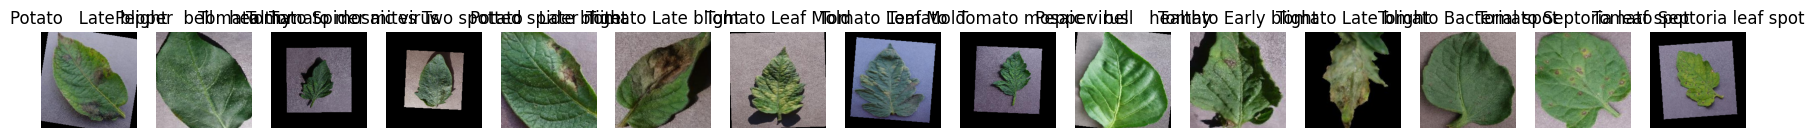

In [ ]:
def visualize_samples(dataset, num_samples=15):
    plt.figure(figsize=(22, 5))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(label_encoder.inverse_transform([label])[0].replace('_',' '))  # Convert label back to class name
        plt.axis('off')
    plt.show()

visualize_samples(train_dataset)

In [ ]:
num_classes = len(label_encoder.classes_)
print(f"Number of Classes: {num_classes}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")


Number of Classes: 15
Device Used: cuda


In [ ]:
model=models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# model = models.resnet50(pretrained=True)
model=model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]


In [ ]:
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.01),
    nn.Linear(num_features, num_classes)
)
model.fc.to(device)

Sequential(
  (0): Dropout(p=0.01, inplace=False)
  (1): Linear(in_features=2048, out_features=15, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # 🔹 Training Phase
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_loss_history.append(train_loss)

        # 🔹 Validation Phase
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(valid_loader)
        val_acc = correct / total
        val_loss_history.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Valid Loss: {val_loss:.4f}, Valid Acc: {val_acc:.4f}")

    return model, train_loss_history, val_loss_history

In [ ]:
num_epochs = 10
trained_model, train_loss, val_loss = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs)

Epoch 1/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.13it/s]


Train Loss: 0.4046, Train Acc: 0.8717
Valid Loss: 0.3841, Valid Acc: 0.8948
Epoch 2/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.19it/s]


Train Loss: 0.1637, Train Acc: 0.9457
Valid Loss: 0.1462, Valid Acc: 0.9540
Epoch 3/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.24it/s]


Train Loss: 0.1249, Train Acc: 0.9583
Valid Loss: 0.1633, Valid Acc: 0.9471
Epoch 4/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.29it/s]


Train Loss: 0.1128, Train Acc: 0.9630
Valid Loss: 0.5114, Valid Acc: 0.8468
Epoch 5/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.28it/s]


Train Loss: 0.0869, Train Acc: 0.9720
Valid Loss: 0.1033, Valid Acc: 0.9618
Epoch 6/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.18it/s]


Train Loss: 0.0853, Train Acc: 0.9702
Valid Loss: 2.0599, Valid Acc: 0.7920
Epoch 7/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.27it/s]


Train Loss: 0.0782, Train Acc: 0.9741
Valid Loss: 0.1167, Valid Acc: 0.9638
Epoch 8/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.21it/s]


Train Loss: 0.0694, Train Acc: 0.9765
Valid Loss: 0.0857, Valid Acc: 0.9736
Epoch 9/10


Validating: 100%|██████████| 64/64 [00:10<00:00,  6.23it/s]


Train Loss: 0.0656, Train Acc: 0.9780
Valid Loss: 0.0856, Valid Acc: 0.9711
Epoch 10/10


Validating: 100%|██████████| 64/64 [00:09<00:00,  6.41it/s]

Train Loss: 0.0650, Train Acc: 0.9794
Valid Loss: 0.0893, Valid Acc: 0.9721


In [ ]:
torch.save(trained_model.state_dict(), "plant_disease_resnet50.pth")
print("Model saved!")

Model saved!


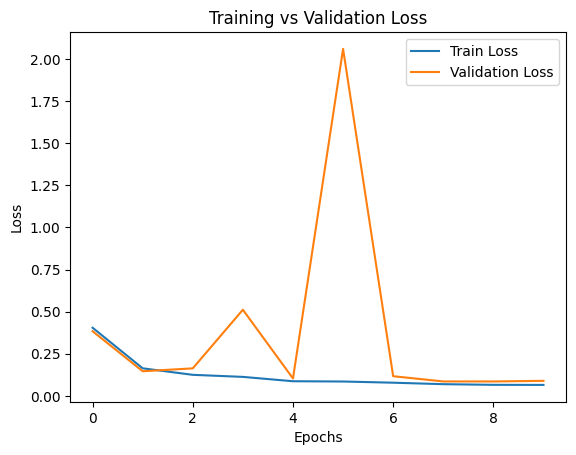

In [ ]:
plt.plot(range(num_epochs), train_loss, label="Train Loss")
plt.plot(range(num_epochs), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"Test Accuracy: {test_acc:.4f}")

# 🔹 Evaluate on Test Data
test_model(trained_model, test_loader)

Testing: 100%|██████████| 130/130 [00:20<00:00,  6.31it/s]

Test Accuracy: 0.9732
